In [70]:
import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

import pickle

In [39]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Columns (3,4,5) have mixed types.", category=UserWarning)
    

os.chdir('..')
os.chdir('Data')
raw_dataframe= pd.read_csv('raw_data.csv', low_memory= False)
os.chdir('..')
os.chdir('Notebooks')

# Problem Statement

*In response to Jet Propulsion Laboratory of California Institute of Technology, this data science project aims to do a binary classification of asteroids for the NEO (Near Earth Object) flag.*

In Astronomy, the size of data is increasing day by day and is becoming more complex than in previous years. Even it is also found in the study of asteroids. There are millions of asteroids to study its classification and calculating its diameter to determine their characteristics. These will help us to know which are potentially hazardous asteroids for Earth.

# Data Handling

## Checking NaN Values

Printing the number columns which have NaN values

In [14]:
missing_percentage = (raw_dataframe.isna().sum() * 100 / len(raw_dataframe)).loc[lambda x: x > 0]

len(missing_percentage)

26

As we have a lot of columns, we are filtering out the columns which have more than 5% of NaN values.

In [16]:
signals = list(map(lambda x: raw_dataframe[x].isna().sum() * 100 / len(raw_dataframe) < 0.5, raw_dataframe.columns))
selected_columns = [column for column, signal in zip(raw_dataframe.columns, signals) if signal]

Making a new dataframe with just these selected columns

In [17]:
dataframe= raw_dataframe[selected_columns]

In [19]:
missing_percentage = (dataframe.isna().sum() * 100 / len(dataframe)).loc[lambda x: x > 0]

missing_percentage

neo        0.000417
ma         0.000104
ad         0.000417
per        0.000417
per_y      0.000104
moid_ld    0.013250
rms        0.000209
dtype: float64

As we have ample of data, dropping the NaN value will be the best bet.

In [21]:
dataframe= dataframe.dropna()

## Checking Duplicated Rows

In [22]:
dataframe.duplicated().sum()

0

No duplicated values in the dataframe.

## Checking Unique Identifiers

In [23]:
columns_with_unique_ids = [column for column in dataframe.columns if dataframe[column].nunique() == len(dataframe)]

columns_with_unique_ids

['id', 'spkid', 'full_name', 'pdes']

Dropping unique ID columns

In [24]:
dataframe.drop(columns_with_unique_ids, axis= 1, inplace= True)

## Checking Constant Columns

Constant columns are the columns with don't provide any discriminatory information as they have a single unique value for all rows.

In [29]:
constant_columns= [column for column in dataframe.columns if dataframe[column].nunique()==1]

constant_columns

['equinox']

Dropping the constant column

In [30]:
dataframe.drop(constant_columns, axis= 1, inplace= True)

# Data Segregation

## Feature - Target Split

In [31]:
features, target= dataframe.drop('neo', axis= 1).copy(), dataframe['neo'].copy()

## Numerical - Categorical Split

In [48]:
numerical_columns= features.select_dtypes(exclude= 'O').columns
categorical_columns= features.select_dtypes(include= 'O').columns

## Encoding Columns

### Target Column Encoding

In [34]:
target= target.map({'N': 0, 'Y': 1})

### Feature's Categorical Columns' Encoding

In [49]:
LE= LabelEncoder()

for column in categorical_columns:
    features[column]= LE.fit_transform(features[column])

# Data Visualization

## Linear Correlation

In [46]:
sample_dataframe= pd.concat([features, target], axis=1).sample(10_000, random_state= 42)

correlation_matrix= sample_dataframe.corr()

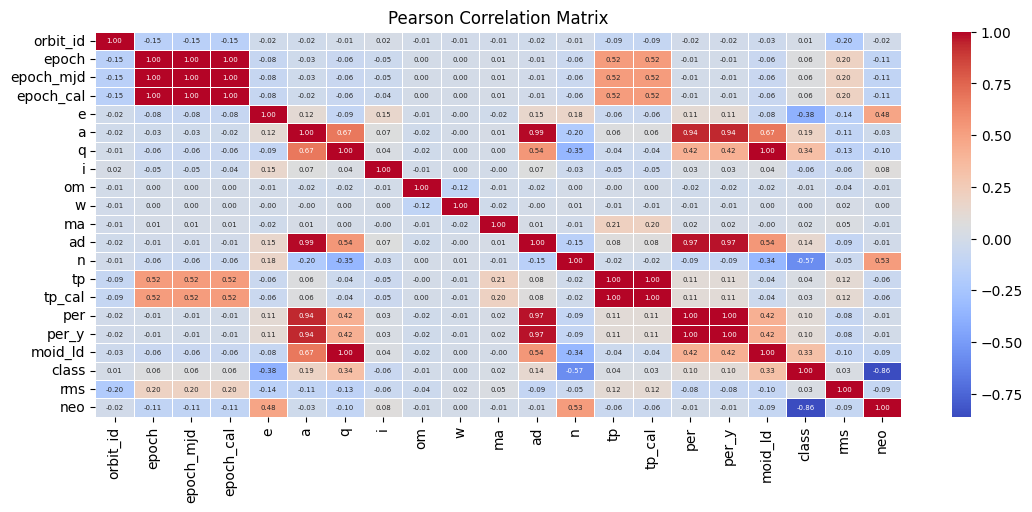

In [51]:
plt.figure(figsize= (13, 5))

sns.heatmap(correlation_matrix,
            fmt= '.2f',
            annot= True,
            linewidths= 0.5,
            cmap= 'coolwarm',
            annot_kws={"size": 5})

plt.title('Pearson Correlation Matrix');

In [54]:
linear_multicollinear_columns= ['epoch_mjd', 'epoch_cal', 'a', 'q', 'ad', 'tp', 'tp_cal', 'per', 'per_y', 'moid_ld']

## Non Linear Correlation

In [56]:
DTR= DecisionTreeRegressor(random_state= 42)
DTR.fit(features, target)

DecisionTreeRegressor(random_state=42)

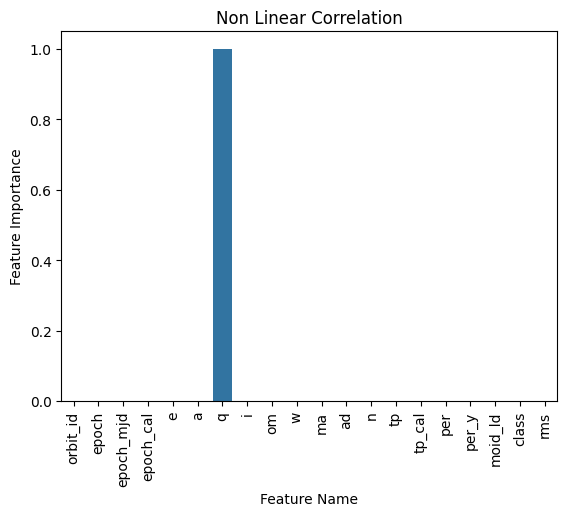

In [59]:
feature_importance= DTR.feature_importances_

sns.barplot(x= features.columns,
            y= feature_importance)
plt.title('Non Linear Correlation')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(rotation= 90);

q is highly collinear with neo. But q is linearly collinear with multiple columns, hence, we are dropping it.

In [61]:
features.drop(linear_multicollinear_columns, axis= 1, inplace= True)

# Saving the Cleaned Data

In [68]:
def pickle_file(dataframe, file_name, folder_name='Data'):
    os.makedirs(folder_name, exist_ok=True)
    full_path = os.path.join(folder_name, file_name)
    with open(full_path, 'wb') as f:
        pickle.dump(dataframe, f)
        print(full_path)

In [69]:
pickle_file(target, 'target.pkl')
pickle_file(features, 'features.pkl')

Data\target.pkl
Data\features.pkl
